In [91]:
%pip install pretty_midi
%pip install tensorflow
%pip install music21
%pip uninstall fluidsynth -y
%pip install --upgrade fluidsynth 

66803.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
66810.86s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
66818.50s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Note: you may need to restart the kernel to use updated packages.
66825.81s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
Found existing installation: fluidsynth 0.2
Uninstalling fluidsynth-0.2:
  Successfully uninstalled fluidsynth-0.2
Note: you may need to restart the kernel to use updated packages.
66831.48s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
  Using cached fluidsynth-0.2-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [126]:
import pandas as pd
import numpy as np
import pretty_midi
import pathlib
import collections
import datetime
import glob
import music21
import tensorflow as tf
import fluidsynth
import my_functions
import importlib


In [129]:
# Global things used throughout the notebook
importlib.reload(my_functions)


seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

# length of trainig sequences
seq_length = 20

# Size of pitch vocab
vocab_size = 128

# Keys that will get extracted into the training set. This are the inputs to the model!
key_order = ['pitch', 'contour', 'step', 'duration', 'tempo']

# Normalizer for keys   This is used to normalize the inputs
#  MUST HAVE SAME DIMENSION AS KEY_ORDER!!
key_normalizer = [vocab_size, 1, 1, 1, 1]

In [94]:
# Load the dataset and massage it for training

# This loads up all the notes in the dataset
pitchInst = my_functions.extract_notes()

# Calc the gap between start of consecutive notes
pitchInst['step'] = pitchInst['start'] - pitchInst['start'].shift(1)

# Fix up the first one cause of the wacky shift problem
pitchInst.loc[0,"step"] = 0

# Calculate the inverval between successive notes
pitchInst['interval'] = (pitchInst['pitch'] - pitchInst['pitch'].shift(1))

# Fix up the first one cause of the wacky shift problem
pitchInst.loc[0, 'interval'] = 0

# apply a contour function
pitchInst['contour'] = pitchInst['interval'].apply(my_functions.contour)

n_notes = len(pitchInst)
pitchInst.head()


,melid,pitch,start,end,duration,instrument,key,style,tempo,feel,step,interval,contour
0,1,65.0,10.343492,10.482268,0.138776,cl,Bb-maj,COOL,218.8,SWING,0.000000,0.0,0.0
1,1,63.0,10.637642,10.808889,0.171247,cl,Bb-maj,COOL,218.8,SWING,0.294150,-2.0,-2.0
2,1,58.0,10.843719,10.924989,0.081270,cl,Bb-maj,COOL,218.8,SWING,0.206077,-5.0,-8.0
3,1,61.0,10.948209,11.183311,0.235102,cl,Bb-maj,COOL,218.8,SWING,0.104490,3.0,3.0
4,1,63.0,11.232653,11.363265,0.130612,cl,Bb-maj,COOL,218.8,SWING,0.284444,2.0,2.0


In [95]:
# get rid of partial training sequences (no end of one song right into the next)

# Create an empty data set with same shape
train_sub = pd.DataFrame(None, columns=pitchInst.columns)

# Loop through all melid values to trim partial seqeunces off
# to do subset just change the start range of the loop to 200 as you had before
# for i in range(pitchInst['melid'].min(), pitchInst['melid'].max(), 1):
for i in range(50, pitchInst['melid'].max(), 1):
    song = pitchInst[pitchInst['melid'] == i]
    # This is not super efficient, but it works.  
    train_sub = pd.concat([train_sub, song.head(len(song) - len(song) % seq_length)], ignore_index=True)  # append only sets of seq_length

train_notes = np.stack([train_sub[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(5,), dtype=tf.float64, name=None)

In [115]:
len(train_sub)

175140

In [96]:
# from tensorFlow MusGen tutorial 
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size: int,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch (is this a good idea?)
  def scale_pitch(x):
    x = x/key_normalizer
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels
    #return inputs, labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [117]:
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.__len__

<bound method DatasetV2.__len__ of <_ParallelMapDataset element_spec=(TensorSpec(shape=(20, 5), dtype=tf.float64, name=None), {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None), 'contour': TensorSpec(shape=(), dtype=tf.float64, name=None), 'step': TensorSpec(shape=(), dtype=tf.float64, name=None), 'duration': TensorSpec(shape=(), dtype=tf.float64, name=None), 'tempo': TensorSpec(shape=(), dtype=tf.float64, name=None)})>>

In [98]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [99]:
train_ds.element_spec

(TensorSpec(shape=(64, 20, 5), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'contour': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'tempo': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [100]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [101]:
# definition for the inpus.  Note how num of inputs is realted to size of key_order global
input_shape = (seq_length, len(key_order))
learning_rate = 0.005

#change input layers here? to suit contour
inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128, return_sequences=True)(inputs)
x = tf.keras.layers.LSTM(64, return_sequences=True)(x)
x = tf.keras.layers.LSTM(32, return_sequences=True)(x)
x = tf.keras.layers.LSTM(128, return_sequences=False)(x)


#and here?
# TODO: Why are there 128 outputs for pitch?
outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch':tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 20, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 20, 128)   │     68,608 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 20, 64)    │     49,408 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 20, 32)    │     12,416 │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 128)       │     82,432 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm_7[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 229,634 (897.01 KB)

 Trainable params: 229,634 (897.01 KB)

 Non-trainable params: 0 (0.00 B)

In [102]:
# these are the three outputs of the model

model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.80,
        'step': 1.0,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [103]:
model.evaluate(train_ds, return_dict=True)

2736/2736 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - duration_loss: 0.0356 - loss: 36.6656 - pitch_loss: 3.8697 - step_loss: 32.7603


/Users/teovargo/anaconda3/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


{'duration_loss': 0.03628361225128174,
 'loss': 37.20989990234375,
 'pitch_loss': 3.868170738220215,
 'step_loss': 33.30546951293945}

64.01315789473684

In [104]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [105]:
%%time
epochs = 50

history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 99s 34ms/step - duration_loss: 0.0341 - loss: 34.3212 - pitch_loss: 2.7662 - step_loss: 31.5210
Epoch 2/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - duration_loss: 0.0233 - loss: 34.2027 - pitch_loss: 2.7038 - step_loss: 31.4756
Epoch 3/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 100s 37ms/step - duration_loss: 0.0234 - loss: 34.2025 - pitch_loss: 2.7047 - step_loss: 31.4745
Epoch 4/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 93s 34ms/step - duration_loss: 0.0234 - loss: 34.1594 - pitch_loss: 2.6603 - step_loss: 31.4757
Epoch 5/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - duration_loss: 0.0234 - loss: 34.0458 - pitch_loss: 2.5487 - step_loss: 31.4737
Epoch 6/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 95s 35ms/step - duration_loss: 0.0234 - loss: 33.7863 - pitch_loss: 2.2859 - step_loss: 31.4771
Epoch 7/50
   3/2736 ━━━━━━━━━━━━━━━━━━━━ 1:30 33ms/step - duration_loss: 0.0156 - loss: 2.2631 - pitch_loss: 2.1570 - step_loss: 0.0905

2024-11-29 11:24:24.377084: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


2736/2736 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - duration_loss: 0.0234 - loss: 33.6106 - pitch_loss: 2.1110 - step_loss: 31.4761
Epoch 8/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 98s 36ms/step - duration_loss: 0.0234 - loss: 33.5960 - pitch_loss: 2.0967 - step_loss: 31.4759
Epoch 9/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 97s 35ms/step - duration_loss: 0.0233 - loss: 33.6148 - pitch_loss: 2.1166 - step_loss: 31.4749
Epoch 10/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 95s 35ms/step - duration_loss: 0.0232 - loss: 33.5823 - pitch_loss: 2.0865 - step_loss: 31.4725
Epoch 11/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 94s 34ms/step - duration_loss: 0.0233 - loss: 33.5624 - pitch_loss: 2.0677 - step_loss: 31.4714
Epoch 12/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 96s 35ms/step - duration_loss: 0.0232 - loss: 33.5602 - pitch_loss: 2.0660 - step_loss: 31.4710
Epoch 13/50
2736/2736 ━━━━━━━━━━━━━━━━━━━━ 86s 31ms/step - duration_loss: 0.0233 - loss: 33.5532 - pitch_loss: 2.0601 - step_loss: 31.4698
Epoch 14/50
2736/2736 ━━━━━━━━━━━━━━━━━━━

In [106]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature 
  pitch = tf.random.categorical(pitch_logits, num_samples=1) 
  pitch = tf.squeeze(pitch, axis=-1) 
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative

  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)
  

  return int(pitch), float(step), float(duration)

In [107]:
data_dir=pathlib.Path('Jazzomat_midi_folder')
filenames = glob.glob(str(data_dir/"*.mid"))
sorted_filenames = sorted(filenames)
sample_file = filenames[8]


In [108]:
temperature = 1.0
num_predictions = 60

# pick one of the midi files
# test_file = sorted_filenames[24]

# test_notes = my_functions.midi_to_notes(test_file)
# # Calculate the inverval between successive notes
# test_notes['interval'] = (test_notes['pitch'] - test_notes['pitch'].shift(1))
# # Fix up the first one cause of the wacky shift problem
# test_notes.loc[0, 'interval'] = 0
# # apply a contour function
# test_notes['contour'] = test_notes['interval'].apply(my_functions.contour)
#easier to sort testing dataframes
#dfs = dict(tuple(pitchInst.groupby('melid')))
song = 25
test_notes = pitchInst[pitchInst['melid'] == song].reset_index()
test_notes.loc[0, 'step'] = 0.0
sample_notes = np.stack([test_notes[key] for key in key_order], axis=1)
# input_notes = tf.data.Dataset.from_tensor_slices(sample_notes[:seq_length])


# The initial sequence of notes; pitch is normalized similar to training sequences
input_notes = (sample_notes[:seq_length] / np.array(key_normalizer))

# This is the tempo of the midi input file...
tempo = test_notes['tempo'].iloc[seq_length]


generated_notes = []
prev_start = 0
input_note = input_notes[-1]
#contour = 0  #initial contour should be last contour of input sequence
for i in range(num_predictions): #THERE ARE PROBLEMS HERE
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  # TODO:  Should this be input_note[0] or the last note?
  interval = pitch - input_note[0]
  contour = my_functions.contour(interval)
  # TODO:
  # This line has to change when you change the inputs to the model.  The input_note
  # that is getting appended to input notes needs to have the correct number of 
  # fields cause it is gonna get fed back into the model.predict function
  input_note = (pitch, contour, step, duration, tempo)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes , np.expand_dims(input_note, 0), axis=0) 
  prev_start = start
  

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

generated_notes.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 508ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━

,pitch,contour,step,duration,tempo,start,end
0,57,16,0.087228,0.113076,82.1,0.087228,0.200304
1,87,16,0.278452,0.178337,82.1,0.365679,0.544017
2,89,2,0.406983,0.201423,82.1,0.772662,0.974085
3,86,-3,0.338327,0.244560,82.1,1.110989,1.355549
4,87,1,0.285382,0.241672,82.1,1.396371,1.638043


In [114]:
test_notes = test_notes[:seq_length]
start_df = test_notes.drop(['interval'], axis=1)
start_df.head()

,index,melid,pitch,start,end,duration,instrument,key,style,tempo,feel,step,contour
0,8986,25,56.0,6.971791,7.035646,0.063855,ts,Ab-maj,SWING,82.1,SWING,0.000000,2.0
1,8987,25,58.0,7.058866,7.105306,0.046440,ts,Ab-maj,SWING,82.1,SWING,0.087075,2.0
2,8988,25,60.0,7.118367,7.273469,0.155102,ts,Ab-maj,SWING,82.1,SWING,0.059501,2.0
3,8989,25,51.0,7.354921,7.665125,0.310204,ts,Ab-maj,SWING,82.1,SWING,0.236553,-8.0
4,8990,25,51.0,7.720635,8.953288,1.232653,ts,Ab-maj,SWING,82.1,SWING,0.365714,0.0


In [110]:
# string together the first training data and the generated notes
full_sequence = pd.concat([start_df, generated_notes], ignore_index=True)
full_sequence[['pitch', 'step', 'duration']].head()


,pitch,step,duration
0,56.0,0.000000,0.063855
1,58.0,0.087075,0.046440
2,60.0,0.059501,0.155102
3,51.0,0.236553,0.310204
4,51.0,0.365714,1.232653


In [111]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [112]:
pm = pretty_midi.PrettyMIDI(sample_file)
example_file = 'contourExampleTempo.midi'
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
example_pm = my_functions.notes_to_midi(full_sequence[['pitch', 'step', 'duration']], out_file=example_file, instrument_name=instrument_name)

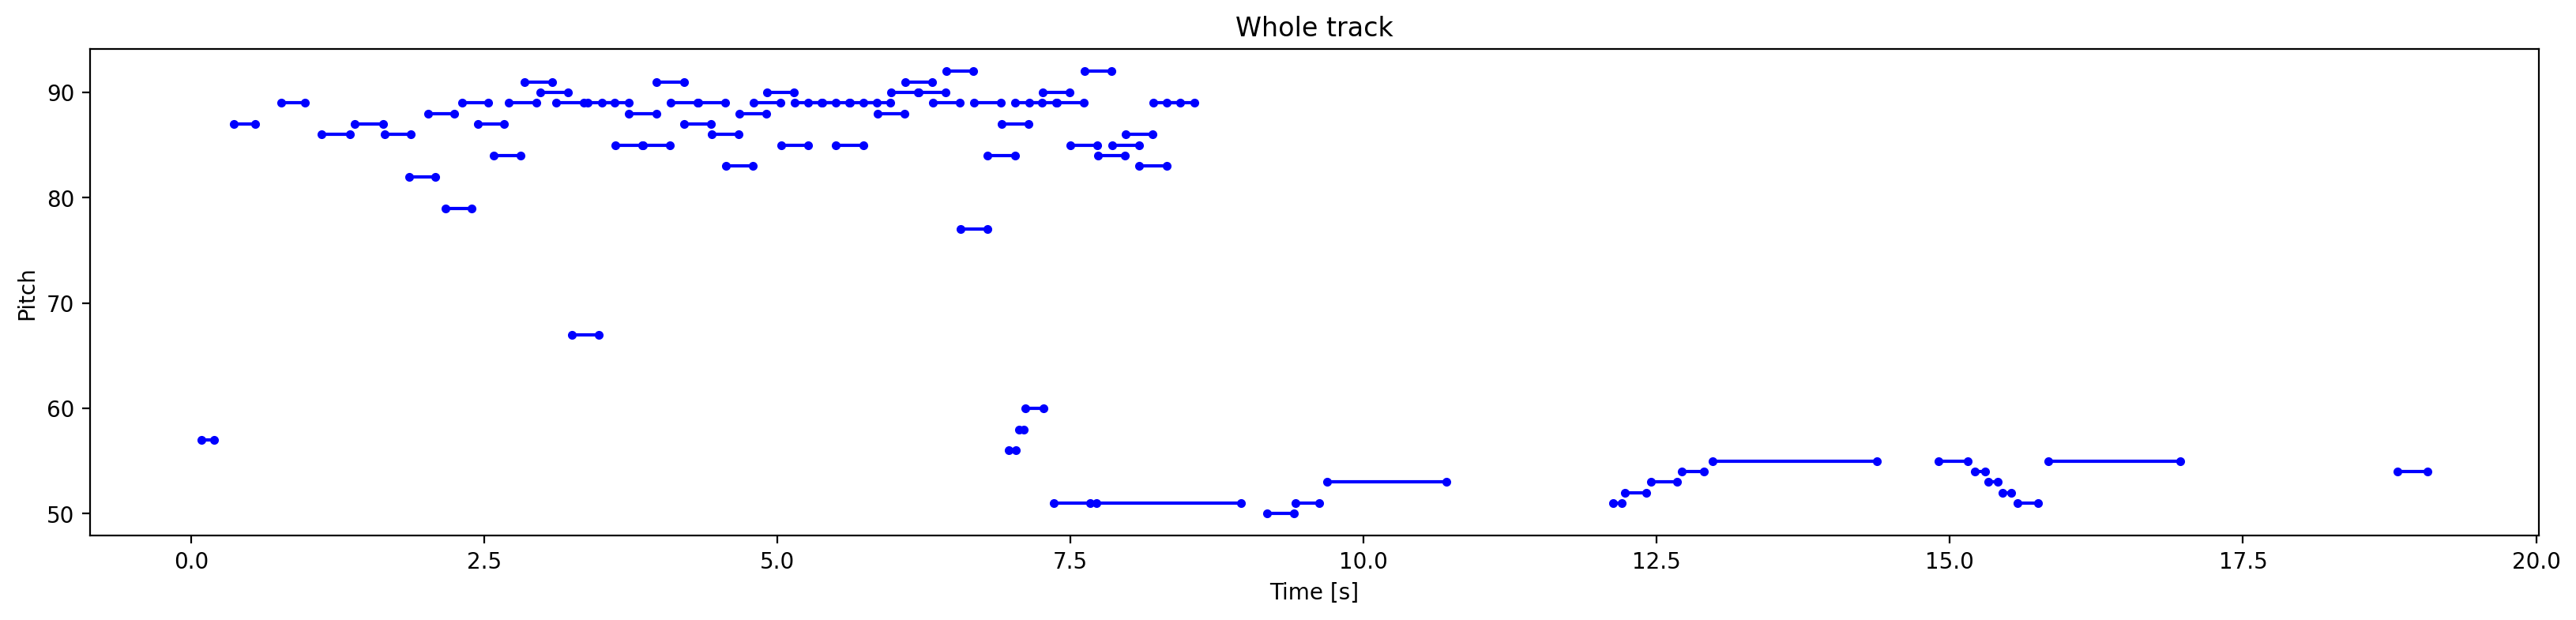

In [128]:
my_functions.plot_piano_roll(full_sequence)

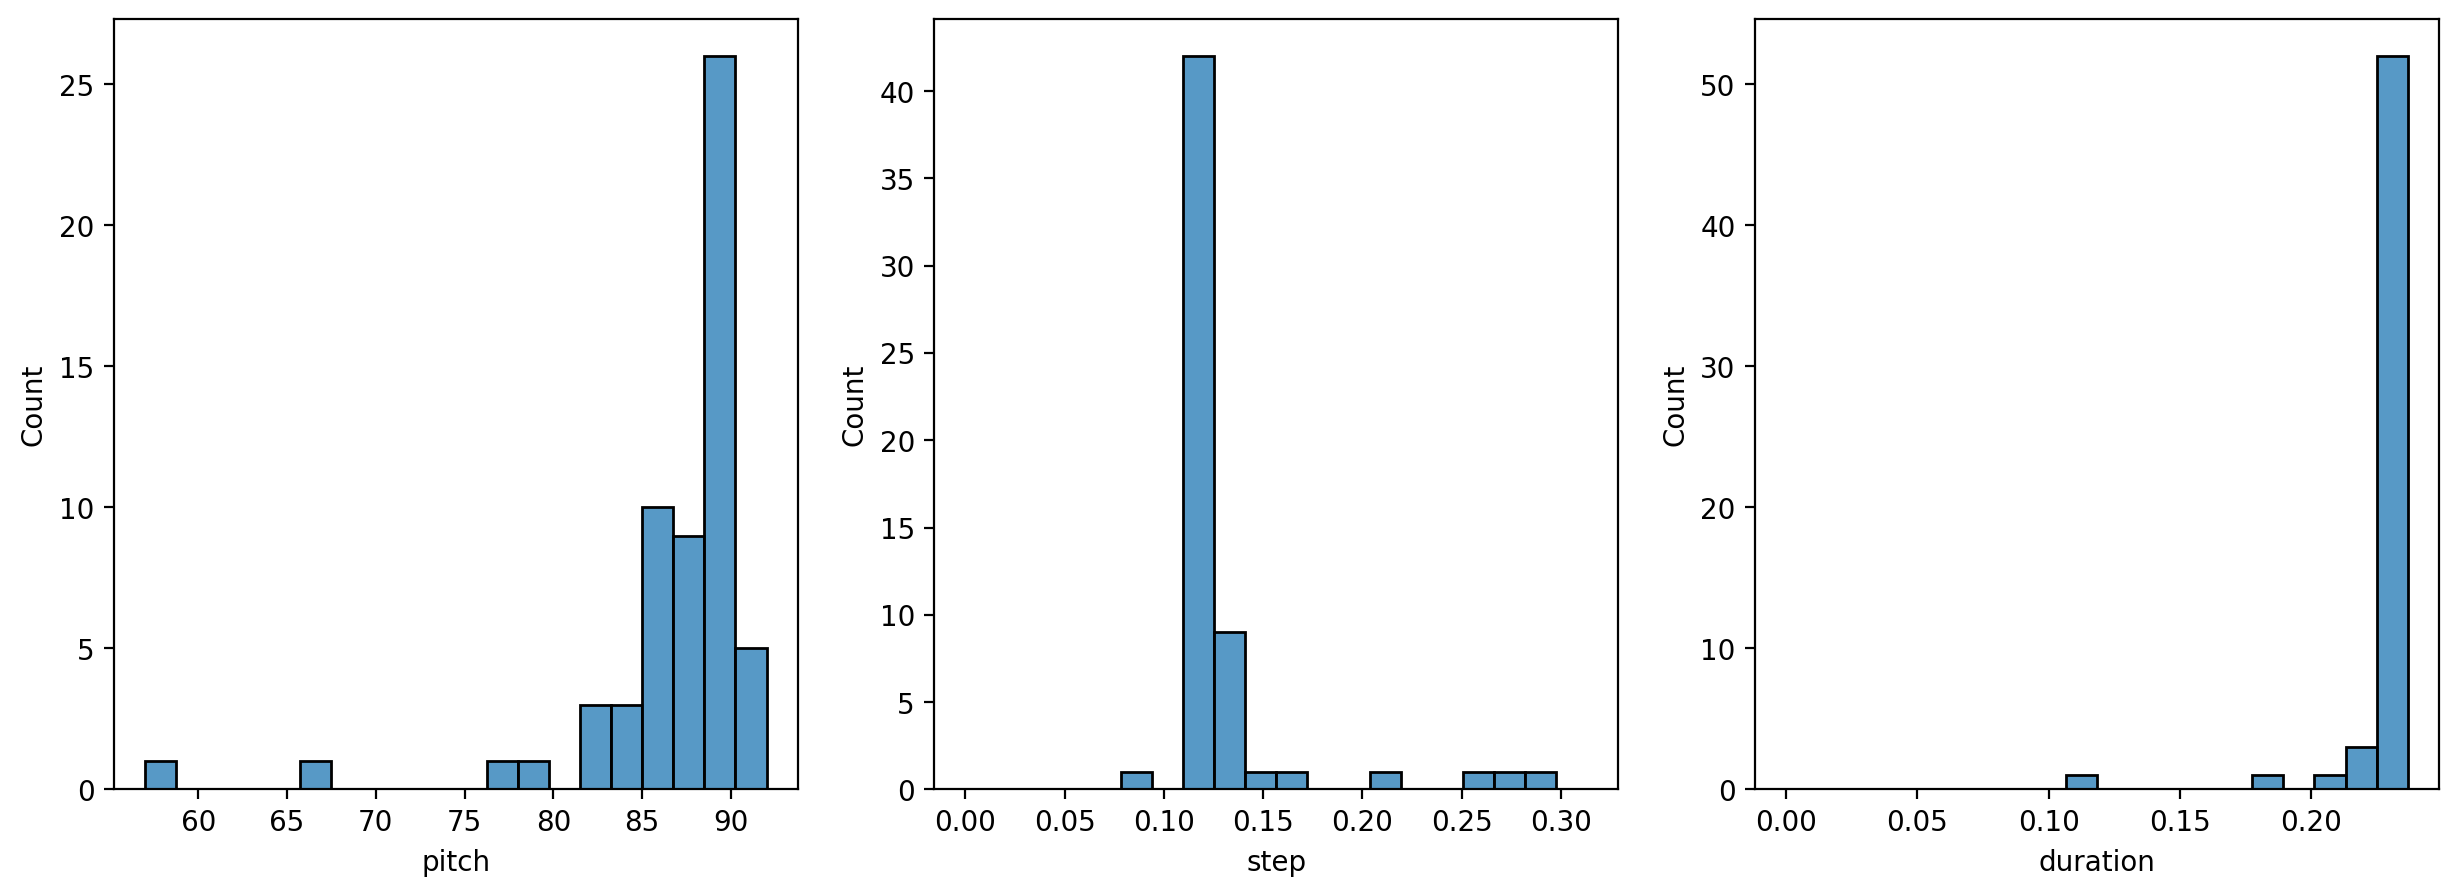

In [130]:
my_functions.plot_distributions(generated_notes)

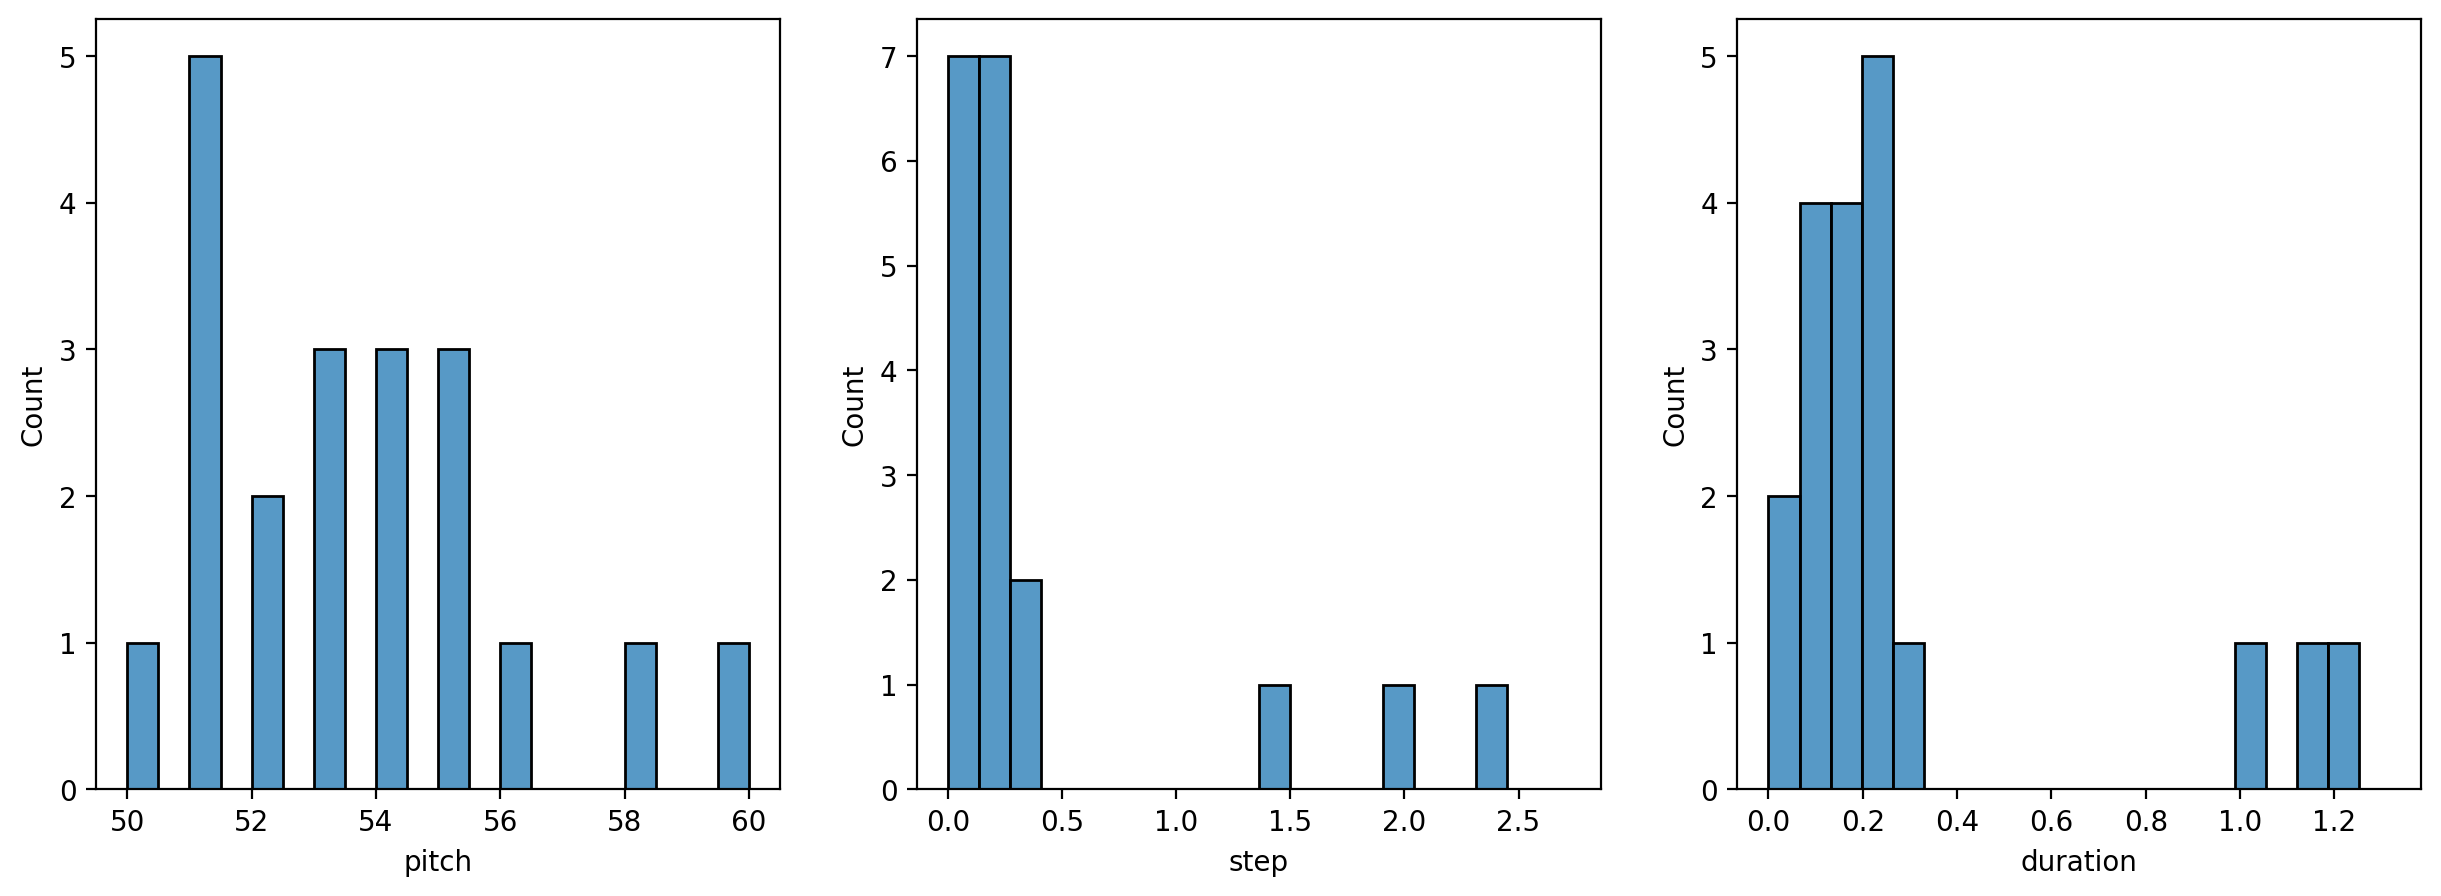

In [131]:
my_functions.plot_distributions(test_notes)